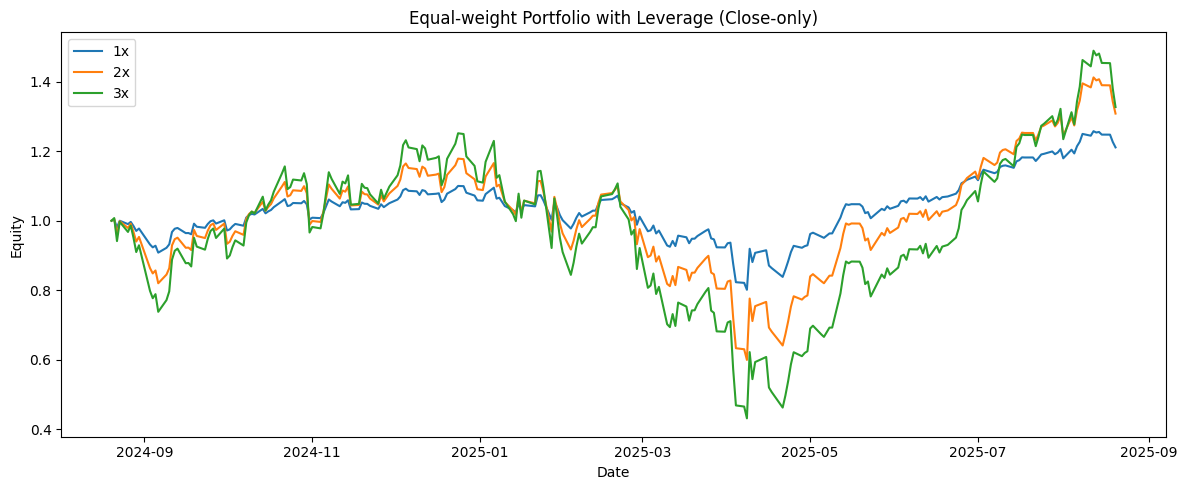

,CumReturn,CAGR,MaxDD,AnnVol,Sharpe,HitRate,Days
Portfolio,,,,,,,
1x,21.10%,21.20%,-27.16%,30.47%,0.78,57.20%,251
2x,30.84%,30.98%,-49.13%,60.94%,0.74,56.97%,251
3x,32.72%,32.87%,-65.53%,91.41%,0.75,56.97%,251


In [1]:
# ===== Leverage backtest mini-demo (single cell) =====
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# ---------- Parameters ----------
tickers = [
    "AAPL",
    "MSFT",
    "NVDA",
    "GOOG",
    "AMZN",
    "META",
    "TSLA",
    "JPM",
    "V",
    "JNJ",
    "XOM",
    "AMD",
    "NFLX",
]
PERIOD = "1y"  # 回看區間，可改 "3mo", "2y"...
INTERVAL = "1d"
AUTO_ADJUST = True  # 調整股利與拆股
DAILY_BORROW_COST = 0.0001  # 每日借款成本（約 2.5% 年化 ≈ 0.0001/天）
INIT_CAPITAL = 1.0  # 權益起始值
LEVS = [1.0, 2.0, 3.0]  # 要比較的槓桿倍數

# ---------- Download & tidy ----------
raw = yf.download(
    TICKERS, period=PERIOD, interval=INTERVAL, auto_adjust=AUTO_ADJUST, progress=False
)

# yfinance 對多檔股票會是 MultiIndex 欄位：例如 ('Close','AAPL')
# 只取 Close，並把欄位扁平為單層
if isinstance(raw.columns, pd.MultiIndex):
    close = raw["Close"].copy()
else:
    # 只有單一商品時
    close = raw.copy()
close = close.dropna(how="all")
# 若只有一檔，把欄位名標準化為 Series -> DataFrame
if isinstance(close, pd.Series):
    close = close.to_frame(name=TICKERS[0])

# ---------- Compute daily equal-weight portfolio return ----------
# 各股日報酬
rets = close.pct_change().fillna(0.0)
# 等權：每天把各股報酬平均
port_daily = rets.mean(axis=1).rename("ret")


# ---------- Leverage function applied on daily returns ----------
def lever_equity(
    daily_ret: pd.Series,
    lev: float = 2.0,
    daily_borrow_cost: float = DAILY_BORROW_COST,
    init_capital: float = INIT_CAPITAL,
) -> pd.Series:
    """
    將每日報酬乘上槓桿，並扣除每日借款成本，回傳權益曲線（起始 = init_capital）
    daily_ret: 1D Series of daily returns
    lev: 槓桿倍數
    daily_borrow_cost: 每日借款成本（單利近似）
    init_capital: 初始資金
    """
    lev_ret = daily_ret.fillna(0.0) * lev - daily_borrow_cost
    eq = (1.0 + lev_ret).cumprod() * init_capital
    return eq


# 基準（不槓桿）權益曲線
eq_base = (1.0 + port_daily).cumprod() * INIT_CAPITAL

# 槓桿版本（2x / 3x）
eq_dict = {"1x": eq_base}
for lev in LEVS:
    if lev == 1.0:
        continue
    eq_dict[f"{int(lev)}x"] = lever_equity(port_daily, lev=lev)

# ---------- Plot ----------
fig, ax = plt.subplots(figsize=(12, 5))
for name, series in eq_dict.items():
    ax.plot(series.index, series, label=name)
ax.set_title("Equal-weight Portfolio with Leverage (Close-only)")
ax.set_ylabel("Equity")
ax.set_xlabel("Date")
ax.legend()
plt.tight_layout()
plt.show()


# ---------- Performance metrics ----------
def max_drawdown(equity: pd.Series) -> float:
    roll_max = equity.cummax()
    dd = equity / roll_max - 1.0
    return dd.min()


def summarize(daily_ret: pd.Series, equity: pd.Series, label: str) -> dict:
    n = len(daily_ret)
    ann_factor = 252
    cum_ret = equity.iloc[-1] / equity.iloc[0] - 1.0
    cagr = (equity.iloc[-1] / equity.iloc[0]) ** (ann_factor / max(1, n)) - 1.0
    ann_vol = daily_ret.std() * np.sqrt(ann_factor)
    sharpe = (daily_ret.mean() / (daily_ret.std() + 1e-12)) * np.sqrt(ann_factor)
    mdd = max_drawdown(equity)
    hitrate = (daily_ret > 0).sum() / max(1, (daily_ret != 0).sum())
    return {
        "Portfolio": label,
        "CumReturn": cum_ret,
        "CAGR": cagr,
        "MaxDD": mdd,
        "AnnVol": ann_vol,
        "Sharpe": sharpe,
        "HitRate": hitrate,
        "Days": n,
    }


# 準備每日報酬（對應於各權益曲線）
perf_rows = []
# 1x
perf_rows.append(summarize(port_daily, eq_base, "1x"))
# 其餘槓桿
for name, eq in eq_dict.items():
    if name == "1x":
        continue
    lev = float(name.replace("x", ""))
    lev_ret = port_daily * lev - DAILY_BORROW_COST
    perf_rows.append(summarize(lev_ret, eq, name))

perf = pd.DataFrame(perf_rows).set_index("Portfolio")
display(
    perf.style.format(
        {
            "CumReturn": "{:.2%}",
            "CAGR": "{:.2%}",
            "MaxDD": "{:.2%}",
            "AnnVol": "{:.2%}",
            "Sharpe": "{:.2f}",
            "HitRate": "{:.2%}",
            "Days": "{:,.0f}",
        }
    )
)